<a href="https://colab.research.google.com/github/qhuy4119/1712858-1712495-nmkhdl/blob/main/TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split


!pip install fairseq
!pip install fastBPE

from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.models.roberta import RobertaModel

!wget https://public.vinai.io/PhoBERT_base_fairseq.tar.gz
!tar -xzvf PhoBERT_base_fairseq.tar.gz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

--2021-01-09 20:30:16--  https://public.vinai.io/PhoBERT_base_fairseq.tar.gz
Resolving public.vinai.io (public.vinai.io)... 99.86.35.23, 99.86.35.72, 99.86.35.98, ...
Connecting to public.vinai.io (public.vinai.io)|99.86.35.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1243308020 (1.2G) [application/x-tar]
Saving to: ‘PhoBERT_base_fairseq.tar.gz.1’

RT_base_fairseq.tar  31%[=====>              ] 371.08M  32.2MB/s    eta 29s    

In [ ]:
data_path=r'/content/drive/MyDrive/Học tập/Introduce Data Science/Đố án/output.csv'

df= pandas.read_csv(data_path)

labels=set(df['forumName'])

data=dict()

for label in labels:
  data[label]=[]

for index,row in df.iterrows():
  for label in labels:
    if row['forumName']==label:
      data[label].append(row['postCotent'])

for label in labels:
  print(label,': ',len(data[label]))

def labelToNum(label):
  for (index, value) in enumerate(labels):
    if value==label:
      return index;
  return 0;

def numToLabel(num):
  for (index, value) in enumerate(labels):
    if index==num:
      return value;
  return data[data.keys()[0]];

df.head()

Phim / Nhạc / Sách :  1463
4 bánh :  1120
Điện thoại di động :  1636
Đồ điện tử & Thiết bị gia dụng :  1340
Chuyện trò linh tinh™ :  1


,postTitle,postCotent,forumName,postLink
0,Bán 8 Plus gold 64g còn bh ở didongviet 10 tháng,"Máy ngoại hình tốt, ko sướt cấn móp. Pin 100%....",Điện thoại di động,https://voz.vn/t/ban-8-plus-gold-64g-con-bh-o-...
1,Mới sắm con máy giặt LG AI DD ưng quá lên khoe...,"Hello mấy thím, nhân hôm không phải trông con ...",Đồ điện tử & Thiết bị gia dụng,https://voz.vn/t/moi-sam-con-may-giat-lg-ai-dd...
2,Những đồ thiết yếu cần lắp cho ô tô,Mời các bác vào tham luận cho vui. cái g...,4 bánh,https://voz.vn/t/nhung-do-thiet-yeu-can-lap-ch...
3,"Thái Mỹ Đình, Ép kính, Ép cáp, Thay Màn, Thay ...","Xin phép Add duyệt bài !!!\nGiúp đỡ , tạo điều...",Điện thoại di động,https://voz.vn/t/thai-my-dinh-ep-kinh-ep-cap-t...
4,"Điện thoại Samsung S9+ hàng ssvn, full box, hì...","Mới nâng cấp máy, cần bán hàng chính hãng SSV...",Điện thoại di động,https://voz.vn/t/dien-thoai-samsung-s9-hang-ss...


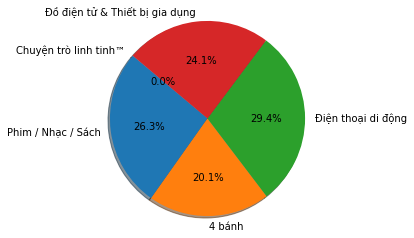

In [ ]:
# Data to plot
labels=labels
countings = []
for label in labels:
  countings.append(len(data[label]))

# Plot
plt.pie(countings, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [ ]:
phoBERT = RobertaModel.from_pretrained('PhoBERT_base_fairseq', checkpoint_file='model.pt')
class BPE():
  bpe_codes = 'PhoBERT_base_fairseq/bpe.codes'

args = BPE()

phoBERT.bpe = fastBPE(args) #Incorporate the BPE encoder into PhoBERT

print(phoBERT)

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerSentenceEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(64001, 768, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(258, 768, padding_idx=1)
        (layers): ModuleList(
          (0): TransformerSentenceEncoderLayer(
            (dropout_module): FairseqDropout()
            (activation_dropout_module): FairseqDropout()
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=T

In [ ]:
MAX_LENGTH=255
WORD_SIZE=768

class GetData(Dataset):
  def __init__(self,data,transform=None):
    self.data= data
    self.transform=transform
    self.dataLoader=[]

  def __len__(self):
    sum=0
    for key in data.keys():
      sum=sum+len(self.data[key])
    return sum

  def getItemHelper(self,idx):
    count=0;
    x=""
    y=0
    for key in self.data.keys():
      for value in data[key]:
        if(count==idx):

          x=str(value).replace('\n',' ');
          y=labelToNum(key)
          if len(x)>MAX_LENGTH:
            x=x[:MAX_LENGTH]
 
          try:
            doc = phoBERT.extract_features_aligned_to_words(x)
            return(doc,y)
          except:
            return self.getItemHelper(idx-1)
        count=count+1
    return (x,y)

  def __getitem__(self,index):
    (x,y)=self.getItemHelper(index)
    
    rs=[]
    for i in range(255):
      try:
        rs.append(x[i].vector.detach().numpy());
        
      except:
        padding=np.zeros(WORD_SIZE)
        rs.append(padding)

    rs=np.array(rs);

    y_label = y

    if self.transform:
      rs=self.transform(rs)

    return (rs,y_label)

In [ ]:
train_size=4000
test_size=1560

transform=transforms.ToTensor()
dataset= GetData(data,transform)
DataLoader
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
batch_size=64

train_loader= DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
input_size=768
sequence_length=255
num_layers=2
hidden_size=256
num_classes=len(data.keys())
learning_rate=0.001
num_epochs=2

# Create RNN
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers,num_classes):
    super(RNN,self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers
    self.rnn= nn.RNN(input_size,hidden_size,num_layers,batch_first=True)
    self.fc=nn.Linear(hidden_size*sequence_length,num_classes)

  def forward(self,x):
    h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
    
    out,_=self.rnn(x,h0)
    out=out.reshape(out.shape[0],-1);
    out=self.fc(out)

    return out;

model = RNN(input_size,hidden_size,num_layers,num_classes);

model(dataset.__getitem__(0)[0].float())

In [ ]:
model= RNN(input_size,hidden_size,num_layers,num_classes).to(device)
criterion= nn.CrossEntropyLoss();
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
# Train Network
for epoch in range(num_epochs):
  for batch_idx,(data_train,targets) in enumerate(train_loader):
    # Get data to Cuda if possible
    #data=data.to(device=device).squeeze(1);
    data_train=data_train.to(device=device).squeeze(1);
    targets=targets.to(device=device);
    
    # Get data ro correct shape
    #data=data.reshape(data.shape[0],-1)
    #data=data.reshape(batch_size,sequence_length,input_size)


    # Forward
    scores=model(data_train.float());
    loss= criterion(scores,targets);

    print(loss)

    # Backward
    optimizer.zero_grad();
    loss.backward();

    # Gradient Descent
    optimizer.step();

tensor(1.6332, grad_fn=<NllLossBackward>)
tensor(1.6332, grad_fn=<NllLossBackward>)
tensor(3.7145, grad_fn=<NllLossBackward>)
tensor(3.7145, grad_fn=<NllLossBackward>)
tensor(1.9373, grad_fn=<NllLossBackward>)
tensor(1.9373, grad_fn=<NllLossBackward>)
tensor(1.3530, grad_fn=<NllLossBackward>)
tensor(1.3530, grad_fn=<NllLossBackward>)
tensor(2.0491, grad_fn=<NllLossBackward>)
tensor(2.0491, grad_fn=<NllLossBackward>)
tensor(1.3643, grad_fn=<NllLossBackward>)
tensor(1.3643, grad_fn=<NllLossBackward>)
tensor(1.4169, grad_fn=<NllLossBackward>)
tensor(1.4169, grad_fn=<NllLossBackward>)
tensor(1.4461, grad_fn=<NllLossBackward>)
tensor(1.4461, grad_fn=<NllLossBackward>)
tensor(1.0679, grad_fn=<NllLossBackward>)
tensor(1.0679, grad_fn=<NllLossBackward>)
tensor(1.0332, grad_fn=<NllLossBackward>)
tensor(1.0332, grad_fn=<NllLossBackward>)
tensor(1.1163, grad_fn=<NllLossBackward>)
tensor(1.1163, grad_fn=<NllLossBackward>)
tensor(0.7917, grad_fn=<NllLossBackward>)
tensor(0.7917, grad_fn=<NllLossBac

In [ ]:
# Check accuracy on training & test to see how good our model

def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on valid data")

    num_correct = 0
    num_samples = 0

    # Set model to eval
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device).squeeze(1)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with \
              accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )
    # Set model back to train
    model.train()

    
check_accuracy(train_loader, model)
check_accuracy(test_loader,model)